In [1]:
#This project goes over a Neural Network problem set using data from airbnb that I completed at Georgetown University while getting my Masters.
#I received a grade of 99/100 and got full credit for the bonus problem set. A report also accompanied this code that goes in depth on my findings.

#The problem set give is below:
#Pre-process the data and prepare it for the running neural network. (35 points)
#Train two different neural network models, using neuralnet package and caret (based on nnet method/package). (35 points)  
#Compare the results of these models by their model evaluation metrics (RMSE, Rsquared, and MAE). Which one is a better model and why? (Hint: caret package has a function that calculates these three regression measures) (15 points)
#You ran two different regression models on the price of the listing (on the same dataset) as part of your Programming I final project. Revisit your findings and comment on the difference between your new models compared to what you ran before? Are the results comparable? Which approach/model is more reliable for prediction? Explain. (5)

In [2]:
library(caret) #For confusionMatrix(), training ML models, and more
library(dplyr) #For some air manipulation and ggplot
library(fastDummies) #To create dummy variable (one hot encoding)
library(ggplot2)
library(neuralnet)

Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘neuralnet’


The following object is masked from ‘package:dplyr’:

    compute




In [3]:
install.packages("sigmoid")
library(sigmoid)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
install.packages("elmNNRcpp")
library(elmNNRcpp)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: KernelKnn



In [5]:
airbnb <- read.csv("/kaggle/input/airbnb/AirbnbListings.csv")

str(airbnb)

summary(airbnb)

'data.frame':	1711 obs. of  13 variables:
 $ listing_id          : num  3571 4197 4373 4375 6165 ...
 $ host_since          : chr  "11/22/2008" "12/12/2008" "12/27/2008" "12/27/2008" ...
 $ host_acceptance_rate: num  NA 0.94 0.62 0.62 1 1 1 0.99 0 1 ...
 $ superhost           : logi  FALSE TRUE TRUE TRUE FALSE FALSE ...
 $ host_total_listings : int  3 2 3 3 18 18 1 6 2 6 ...
 $ neighborhood        : chr  "Georgetown" "CapitolHill" "Takoma" "Takoma" ...
 $ room_type           : chr  NA "PrivateRoom" "PrivateRoom" "PrivateRoom" ...
 $ accommodates        : int  6 1 2 1 1 1 2 1 1 2 ...
 $ beds                : int  2 1 1 1 1 1 1 1 1 1 ...
 $ min_nights          : int  90 7 28 28 31 31 31 7 31 180 ...
 $ total_reviews       : int  9 47 24 40 22 9 NA 38 130 32 ...
 $ avg_rating          : num  4.5 4.84 4.9 4.81 4.94 4.5 NA 4.63 4.87 4.93 ...
 $ price               : int  200 70 40 40 82 53 135 59 50 68 ...


   listing_id         host_since        host_acceptance_rate superhost      
 Min.   :3.571e+03   Length:1711        Min.   :0.0000       Mode :logical  
 1st Qu.:1.688e+07   Class :character   1st Qu.:0.9000       FALSE:1097     
 Median :3.442e+07   Mode  :character   Median :0.9800       TRUE :614      
 Mean   :5.901e+16                      Mean   :0.8989                      
 3rd Qu.:4.917e+07                      3rd Qu.:1.0000                      
 Max.   :6.950e+17                      Max.   :1.0000                      
                                        NA's   :187                         
 host_total_listings neighborhood        room_type          accommodates   
 Min.   :   1.0      Length:1711        Length:1711        Min.   : 1.000  
 1st Qu.:   1.0      Class :character   Class :character   1st Qu.: 2.000  
 Median :   4.0      Mode  :character   Mode  :character   Median : 3.000  
 Mean   : 126.4                                            Mean   : 3.521  
 3rd

In [6]:
airbnb_dummies = dummy_cols(airbnb, select_columns = c('neighborhood', 'room_type'))

final_air  =  airbnb_dummies %>% 
  select (-c(listing_id, neighborhood, room_type, room_type_SharedRoom, neighborhood_Bellevue))


final_air$year = as.numeric(format(as.Date(final_air$host_since, format = "%m/%d/%Y"), "%Y"))

final_air$total_years <- as.numeric(2023 - final_air$year)

final_air = final_air %>% select(-c(host_since))

final_air$superhost <- as.integer(as.logical(final_air$superhost))

final_air  =  final_air %>% 
  select (-c(year))

final_air <- rename(final_air, 'room_type_Entire' = 'room_type_EntireHome/apt')

In [7]:
###Removing Outliers###
final_air = final_air[-which(final_air$price > 650), ]


str(final_air)

summary(final_air)

set.seed(123)

lotto = sample(nrow(final_air), .7*nrow(final_air))

train_air = final_air[lotto,]

test_air = final_air[-lotto,]

sapply(train_air, function(x){sum(is.na(x))})

sapply(test_air, function(x){sum(is.na(x))})

'data.frame':	1694 obs. of  20 variables:
 $ host_acceptance_rate     : num  NA 0.94 0.62 0.62 1 1 1 0.99 0 1 ...
 $ superhost                : int  0 1 1 1 0 0 0 1 0 1 ...
 $ host_total_listings      : int  3 2 3 3 18 18 1 6 2 6 ...
 $ accommodates             : int  6 1 2 1 1 1 2 1 1 2 ...
 $ beds                     : int  2 1 1 1 1 1 1 1 1 1 ...
 $ min_nights               : int  90 7 28 28 31 31 31 7 31 180 ...
 $ total_reviews            : int  9 47 24 40 22 9 NA 38 130 32 ...
 $ avg_rating               : num  4.5 4.84 4.9 4.81 4.94 4.5 NA 4.63 4.87 4.93 ...
 $ price                    : int  200 70 40 40 82 53 135 59 50 68 ...
 $ neighborhood_CapitolHill : int  0 1 0 0 0 0 0 0 0 0 ...
 $ neighborhood_Downtown    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ neighborhood_DupontCircle: int  0 0 0 0 0 0 1 0 0 0 ...
 $ neighborhood_FortMcNair  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ neighborhood_Georgetown  : int  1 0 0 0 0 0 0 0 0 1 ...
 $ neighborhood_Petworth    : int  0 0 0 0 1 1 0 1 0 0 ...
 $ 

 host_acceptance_rate   superhost      host_total_listings  accommodates   
 Min.   :0.000        Min.   :0.0000   Min.   :   1.00     Min.   : 1.000  
 1st Qu.:0.900        1st Qu.:0.0000   1st Qu.:   1.00     1st Qu.: 2.000  
 Median :0.980        Median :0.0000   Median :   4.00     Median : 3.000  
 Mean   :0.899        Mean   :0.3566   Mean   : 123.48     Mean   : 3.479  
 3rd Qu.:1.000        3rd Qu.:1.0000   3rd Qu.:  20.25     3rd Qu.: 4.000  
 Max.   :1.000        Max.   :1.0000   Max.   :7013.00     Max.   :16.000  
 NA's   :187                                                               
      beds         min_nights     total_reviews      avg_rating   
 Min.   :1.000   Min.   :  1.00   Min.   :  1.00   Min.   :0.000  
 1st Qu.:1.000   1st Qu.:  2.00   1st Qu.:  6.00   1st Qu.:4.670  
 Median :2.000   Median :  7.00   Median : 24.00   Median :4.860  
 Mean   :1.846   Mean   : 19.11   Mean   : 59.41   Mean   :4.726  
 3rd Qu.:2.000   3rd Qu.: 31.00   3rd Qu.: 73.00   3rd Qu

host_acceptance_rate                 superhost       host_total_listings 
                      128                         0                         0 
             accommodates                      beds                min_nights 
                        0                         0                         0 
            total_reviews                avg_rating                     price 
                       13                        13                         0 
 neighborhood_CapitolHill     neighborhood_Downtown neighborhood_DupontCircle 
                        0                         0                         0 
  neighborhood_FortMcNair   neighborhood_Georgetown     neighborhood_Petworth 
                        0                         0                         0 
      neighborhood_Takoma          room_type_Entire     room_type_PrivateRoom 
                        0                        15                        15 
             room_type_NA               total_years 
                        0                         0

host_acceptance_rate                 superhost       host_total_listings 
                       59                         0                         0 
             accommodates                      beds                min_nights 
                        0                         0                         0 
            total_reviews                avg_rating                     price 
                        4                         4                         0 
 neighborhood_CapitolHill     neighborhood_Downtown neighborhood_DupontCircle 
                        0                         0                         0 
  neighborhood_FortMcNair   neighborhood_Georgetown     neighborhood_Petworth 
                        0                         0                         0 
      neighborhood_Takoma          room_type_Entire     room_type_PrivateRoom 
                        0                         5                         5 
             room_type_NA               total_years 
                        0                         0

In [8]:
#Seeing what percentage of air is missing 
sum(is.na(train_air$total_reviews))/nrow(train_air)

sum(is.na(train_air$avg_rating))/nrow(train_air)

sum(is.na(train_air$`room_type_Entire`))/nrow(train_air) #privateroom and shared room will also be same percentage

[1] 0.01097046

[1] 0.01097046

[1] 0.01265823

In [9]:
#NOW WE ARE GOING TO REPLACE THE MISSING VALUES###
train_air[is.na(train_air$avg_rating),'avg_rating'] = mean(train_air$avg_rating,na.rm=TRUE) 

train_air[is.na(train_air$host_acceptance_rate),'host_acceptance_rate'] = mean(train_air$host_acceptance_rate,na.rm=TRUE) 

train_air[is.na(train_air$total_reviews),'total_reviews'] = mean(train_air$total_reviews,na.rm=TRUE)

#Here we are replacing the NAs with 0 since the room style is unknown and not a value
train_air[is.na(train_air)] <- 0


#now taking the training air imputation results and input them into the test air

test_air[is.na(test_air$avg_rating),'avg_rating'] = mean(train_air$avg_rating,na.rm=TRUE) 

test_air[is.na(test_air$host_acceptance_rate),'host_acceptance_rate'] = mean(train_air$host_acceptance_rate,na.rm=TRUE) 

test_air[is.na(test_air$total_reviews),'total_reviews'] = mean(train_air$total_reviews,na.rm=TRUE) 

test_air[is.na(test_air)] <- 0


###CHECK FOR MISSING data AGAIN###
sapply(train_air, function(x){sum(is.na(x))})

sapply(test_air, function(x){sum(is.na(x))})

host_acceptance_rate                 superhost       host_total_listings 
                        0                         0                         0 
             accommodates                      beds                min_nights 
                        0                         0                         0 
            total_reviews                avg_rating                     price 
                        0                         0                         0 
 neighborhood_CapitolHill     neighborhood_Downtown neighborhood_DupontCircle 
                        0                         0                         0 
  neighborhood_FortMcNair   neighborhood_Georgetown     neighborhood_Petworth 
                        0                         0                         0 
      neighborhood_Takoma          room_type_Entire     room_type_PrivateRoom 
                        0                         0                         0 
             room_type_NA               total_years 
                        0                         0

host_acceptance_rate                 superhost       host_total_listings 
                        0                         0                         0 
             accommodates                      beds                min_nights 
                        0                         0                         0 
            total_reviews                avg_rating                     price 
                        0                         0                         0 
 neighborhood_CapitolHill     neighborhood_Downtown neighborhood_DupontCircle 
                        0                         0                         0 
  neighborhood_FortMcNair   neighborhood_Georgetown     neighborhood_Petworth 
                        0                         0                         0 
      neighborhood_Takoma          room_type_Entire     room_type_PrivateRoom 
                        0                         0                         0 
             room_type_NA               total_years 
                        0                         0

In [10]:
###Scaling the data###
scale_vals = preProcess(train_air, method="range")

train_air_s = predict(scale_vals, train_air)

test_air_s = predict(scale_vals, test_air)

In [11]:
###Step 2 Creating NN Models###

NN1 = neuralnet(price~.,
                data=train_air_s,
                linear.output = TRUE,
                stepmax = 1e+07,
                act.fct = relu,
                hidden=4)


plot(NN1) 

NN1$result.matrix


pred1 = predict(NN1, test_air_s)
#Scaling back predicted values to the actual scale of price
pred1_acts = pred1*(max(train_air$price)-min(train_air$price))+min(train_air$price)

plot(test_air$price,pred1_acts, xlab="Price",ylab="Predicted Price",main="Model 1")

error,10.60452310
reached.threshold,0.00683673
steps,1356.00000000
Intercept.to.1layhid1,-1.49050763
host_acceptance_rate.to.1layhid1,0.06204139
superhost.to.1layhid1,-1.41641641
host_total_listings.to.1layhid1,1.32853046
accommodates.to.1layhid1,-0.03940865
beds.to.1layhid1,-1.20100361
min_nights.to.1layhid1,-0.25895407
total_reviews.to.1layhid1,-0.85245320


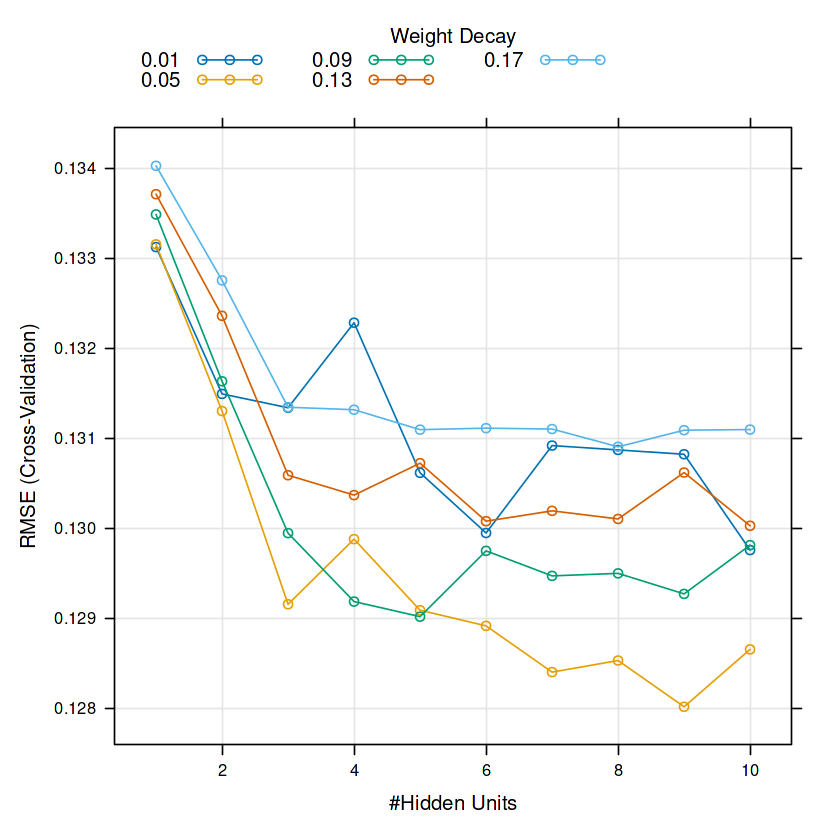

In [12]:
#Model 2
ctrl = trainControl(method="cv",number=10)

myGrid = expand.grid(size = seq(1,10,1),
                     decay = seq(0.01,0.2,0.04))





set.seed(123)

NN2 = train(
  price ~ ., data = train_air_s,
  linout = TRUE,
  method = "nnet", 
  tuneGrid = myGrid,
  trControl = ctrl,
  trace=FALSE)

#NN2
plot(NN2)


RMSE   Rsquared        MAE 
83.6261350  0.3869447 60.6404397

RMSE   Rsquared        MAE 
79.5418150  0.4448219 56.9203409

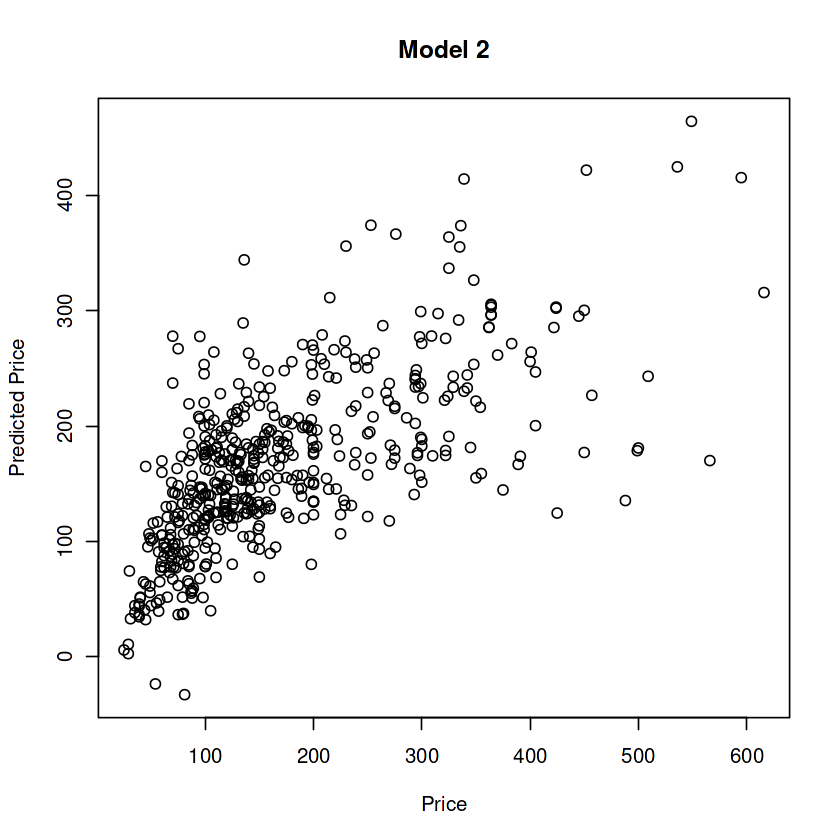

In [13]:
#predicted values for test data (these will be between 0 and 1)
pred2 = predict(NN2, test_air_s)

#Scaling back predicted values to the actual scale of price
pred2_acts = pred2*(max(train_air$price)-min(train_air$price))+min(train_air$price)

plot(test_air$price,pred2_acts,xlab="Price",ylab="Predicted Price",main="Model 2")


#MODEL COMPARISON#
postResample(pred1_acts,test_air$price) #Model 1

postResample(pred2_acts,test_air$price) #Model 2

Extreme learning model, elm (regression):

call:  elm(price ~ ., data = train_air_s, nhid = 5, actfun = "relu") 
hidden units       : 5 
activation function: relu 
mse                : 0.03805097 

RMSE     Rsquared          MAE 
1.296432e+02 1.467835e-04 9.047335e+01

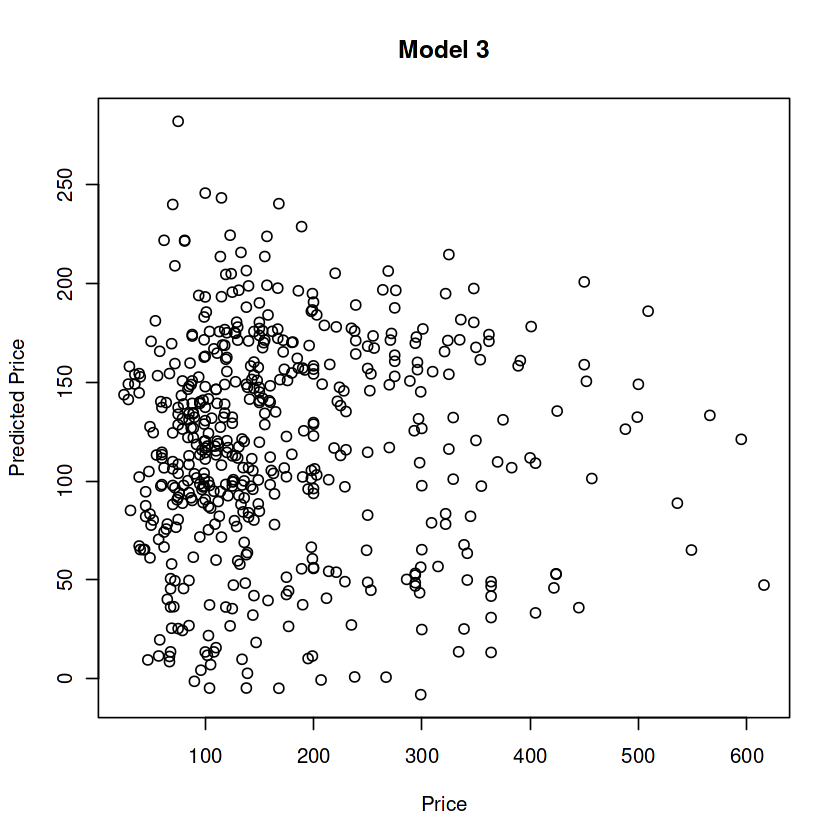

In [14]:
###BONUS QUESTION NN CODE###

NN3 = elm(price~.,
             data = train_air_s,
             nhid = 5,
             actfun = "relu")

NN3

# Predict with elmNNRcpp #

NN3_predict = predict(NN3,test_air_s)

# Rescale #

NN3_pred_actual = NN3_predict*max((train_air$price)-min(train_air$price)+min(train_air$price))

postResample(NN3_pred_actual,test_air$price)

plot(test_air$price, NN3_pred_actual,xlab="Price",ylab="Predicted Price",main="Model 3")